# Balanced Model Architecture Analysis

This notebook analyzes the performance of our fiber orientation prediction model using balanced datasets:

1. Raw vs Balanced Data Performance
2. Cross-Domain Generalization with Balanced Data
3. Feature Space Analysis
4. Model Robustness Study

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import pickle

# Add src directory to Python path for imports
sys.path.append(os.path.abspath('../../src'))

# Import from our package
from fiber_predictor.svr_hog.data_processing import HogDataset, balance_dataset
from fiber_predictor.svr_hog.models import FiberPredictor

IMAGE_DIR = '../../images'
MODEL_DIR = '../../models'

In [3]:
# HOG parameters
grid_quotient = np.arange(1, 4)
orientations = 10

# Dataset paths
bio_file_dir = os.path.join(IMAGE_DIR, "bio/")
bio_csv_dir = os.path.join(IMAGE_DIR, "bio/labels.csv")
diff_file_dir = os.path.join(IMAGE_DIR, "diffusion/")
diff_csv_dir = os.path.join(IMAGE_DIR, "diffusion/labels.csv")

# Define bins for balancing (every 20 degrees)
ANGLE_BINS = np.arange(0, 181, 20)

In [4]:
def load_and_process_data(file_dir, csv_dir, augment=False, balance=False):
    """Load and process dataset with optional augmentation and balancing"""
    dataset = HogDataset(
        labels_path=csv_dir,
        file_dir=file_dir,
        grid_quotient=grid_quotient,
        orientations=orientations,
        augment_whole_dataset=augment
    )
    
    if balance:
        balance_dataset(dataset, ANGLE_BINS)
    
    feature_matrix = []
    labels = []
    file_paths = []
    
    for idx in range(len(dataset)):
        file_path, features_tensor, angle = dataset[idx]
        feature_matrix.append(features_tensor.numpy())
        labels.append(angle)
        file_paths.append(file_path)
    
    return {
        'features': np.array(feature_matrix),
        'labels': np.array(labels),
        'file_paths': np.array(file_paths),
        'n_samples': len(labels),
        'n_features': feature_matrix[0].shape[0]
    }

# Load all datasets
print("Loading datasets...")
bio_raw = load_and_process_data(bio_file_dir, bio_csv_dir)
bio_balanced = load_and_process_data(bio_file_dir, bio_csv_dir, balance=True)
bio_aug_balanced = load_and_process_data(bio_file_dir, bio_csv_dir, augment=True, balance=True)
diff_raw = load_and_process_data(diff_file_dir, diff_csv_dir)
diff_balanced = load_and_process_data(diff_file_dir, diff_csv_dir, balance=True)

# Print dataset information
print("\nDataset sizes:")
print(f"Raw Biological: {bio_raw['n_samples']} samples")
print(f"Balanced Biological: {bio_balanced['n_samples']} samples")
print(f"Augmented+Balanced Biological: {bio_aug_balanced['n_samples']} samples")
print(f"Raw Diffusion: {diff_raw['n_samples']} samples")
print(f"Balanced Diffusion: {diff_balanced['n_samples']} samples")

Loading datasets...

Dataset sizes:
Raw Biological: 673 samples
Balanced Biological: 108 samples
Augmented+Balanced Biological: 1008 samples
Raw Diffusion: 609 samples
Balanced Diffusion: 306 samples


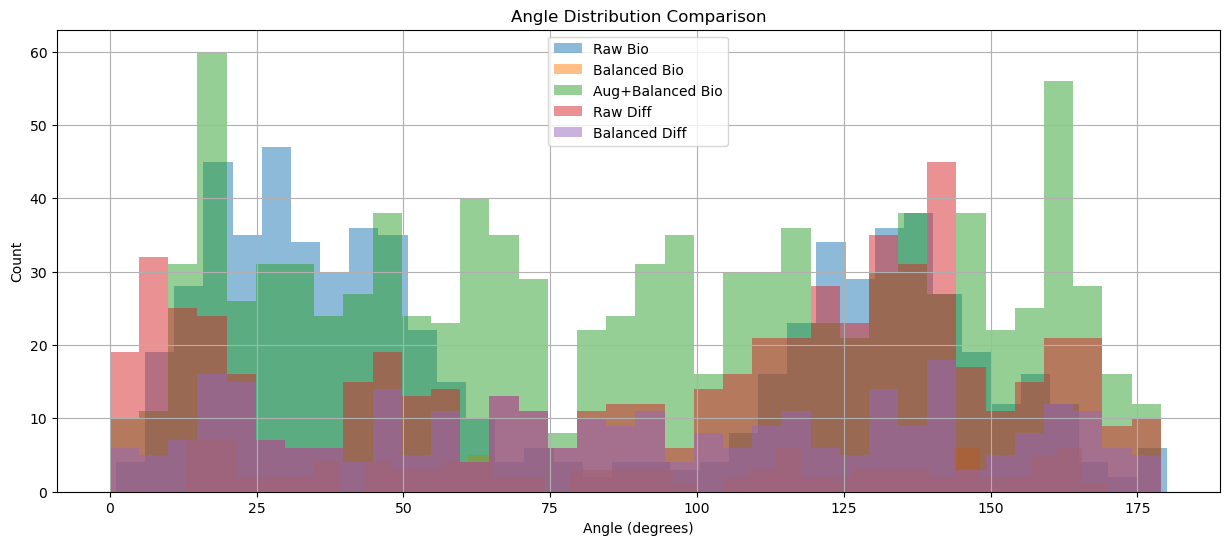

In [5]:
def plot_angle_distributions(datasets, names, bins=36):
    """Plot angle distributions for multiple datasets"""
    plt.figure(figsize=(15, 6))
    
    for data, name in zip(datasets, names):
        plt.hist(data['labels'], bins=bins, alpha=0.5, label=name)
    
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Count')
    plt.title('Angle Distribution Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot distributions
plot_angle_distributions(
    [bio_raw, bio_balanced, bio_aug_balanced, diff_raw, diff_balanced],
    ['Raw Bio', 'Balanced Bio', 'Aug+Balanced Bio', 'Raw Diff', 'Balanced Diff']
)

In [6]:
def train_evaluate_model(X_train, y_train, test_sets, model_name=None):
    """Train model and evaluate on multiple test sets"""
    # Split training data
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.3, random_state=42
    )
    
    # Initialize and train model
    model = FiberPredictor(
        scaler_type="Standard",
        pca_params={"n_components": 0.95},
        regressor_type="SVR",
        regressor_params={"kernel": "rbf", "C": 100, "gamma": 0.01}
    )
    model.fit(X_train_split, y_train_split)
    
    # Evaluate
    results = {
        'model_name': model_name,
        'n_train': len(X_train_split),
        'n_val': len(X_val)
    }
    
    # Validation performance
    val_pred = model.predict(X_val)
    results['val_mae'] = mean_absolute_error(y_val, val_pred)
    results['val_r2'] = r2_score(y_val, val_pred)
    
    # Test set performance
    for name, (X_test, y_test) in test_sets.items():
        y_pred = model.predict(X_test)
        results[f'{name}_mae'] = mean_absolute_error(y_test, y_pred)
        results[f'{name}_r2'] = r2_score(y_test, y_pred)
        results[f'{name}_pred'] = y_pred
        results[f'{name}_true'] = y_test
    
    # Save model if name provided
    if model_name:
        with open(os.path.join(MODEL_DIR, f'svr_hog/{model_name}.pkl'), 'wb') as f:
            pickle.dump(model, f)
    
    return results

# Training scenarios
scenarios = [
    {
        'name': 'raw_bio',
        'train_features': bio_raw['features'],
        'train_labels': bio_raw['labels'],
        'test_sets': {
            'raw_diff': (diff_raw['features'], diff_raw['labels']),
            'balanced_diff': (diff_balanced['features'], diff_balanced['labels'])
        }
    },
    {
        'name': 'balanced_bio',
        'train_features': bio_balanced['features'],
        'train_labels': bio_balanced['labels'],
        'test_sets': {
            'raw_diff': (diff_raw['features'], diff_raw['labels']),
            'balanced_diff': (diff_balanced['features'], diff_balanced['labels'])
        }
    },
    {
        'name': 'aug_balanced_bio',
        'train_features': bio_aug_balanced['features'],
        'train_labels': bio_aug_balanced['labels'],
        'test_sets': {
            'raw_bio': (bio_raw['features'], bio_raw['labels']),
            'raw_diff': (diff_raw['features'], diff_raw['labels']),
            'balanced_diff': (diff_balanced['features'], diff_balanced['labels'])
        }
    }
]

# Train and evaluate all scenarios
results = []
for scenario in scenarios:
    print(f"\nTraining {scenario['name']} model...")
    result = train_evaluate_model(
        scenario['train_features'],
        scenario['train_labels'],
        scenario['test_sets'],
        model_name=scenario['name']
    )
    results.append(result)

# Create summary DataFrame
summary_df = pd.DataFrame(results)
print("\nModel Performance Summary:")
display(summary_df)


Training raw_bio model...

Training balanced_bio model...

Training aug_balanced_bio model...

Model Performance Summary:


,model_name,n_train,n_val,val_mae,val_r2,raw_diff_mae,raw_diff_r2,raw_diff_pred,raw_diff_true,balanced_diff_mae,balanced_diff_r2,balanced_diff_pred,balanced_diff_true,raw_bio_mae,raw_bio_r2,raw_bio_pred,raw_bio_true
0,raw_bio,471,202,14.166508,0.727839,16.814022,0.752222,"[111.25825240095713, 117.29675775396669, 104.5...","[109, 138, 124, 138, 77, 153, 141, 135, 148, 1...",15.703091,0.732808,"[111.84319950228998, 108.08911555685037, 108.6...","[105, 118, 106, 104, 117, 112, 112, 108, 110, ...",NaN,NaN,NaN,NaN
1,balanced_bio,75,33,11.634980,0.903494,16.484701,0.764679,"[115.79724494655271, 120.58969964239323, 114.5...","[109, 138, 124, 138, 77, 153, 141, 135, 148, 1...",15.505175,0.762349,"[111.56891384822158, 118.2466435399676, 109.00...","[105, 118, 106, 104, 117, 112, 112, 108, 110, ...",NaN,NaN,NaN,NaN
2,aug_balanced_bio,705,303,14.135340,0.703191,15.722916,0.778639,"[121.24259764458593, 112.09285736477017, 121.0...","[109, 138, 124, 138, 77, 153, 141, 135, 148, 1...",13.801919,0.809515,"[103.43898559870159, 120.92689460409845, 100.1...","[105, 118, 106, 104, 117, 112, 112, 108, 110, ...",14.995885,0.75003,"[94.970442599239, 77.08194092110023, 51.702497...","[47, 48, 59, 36, 58, 39, 58, 45, 43, 42, 49, 5..."


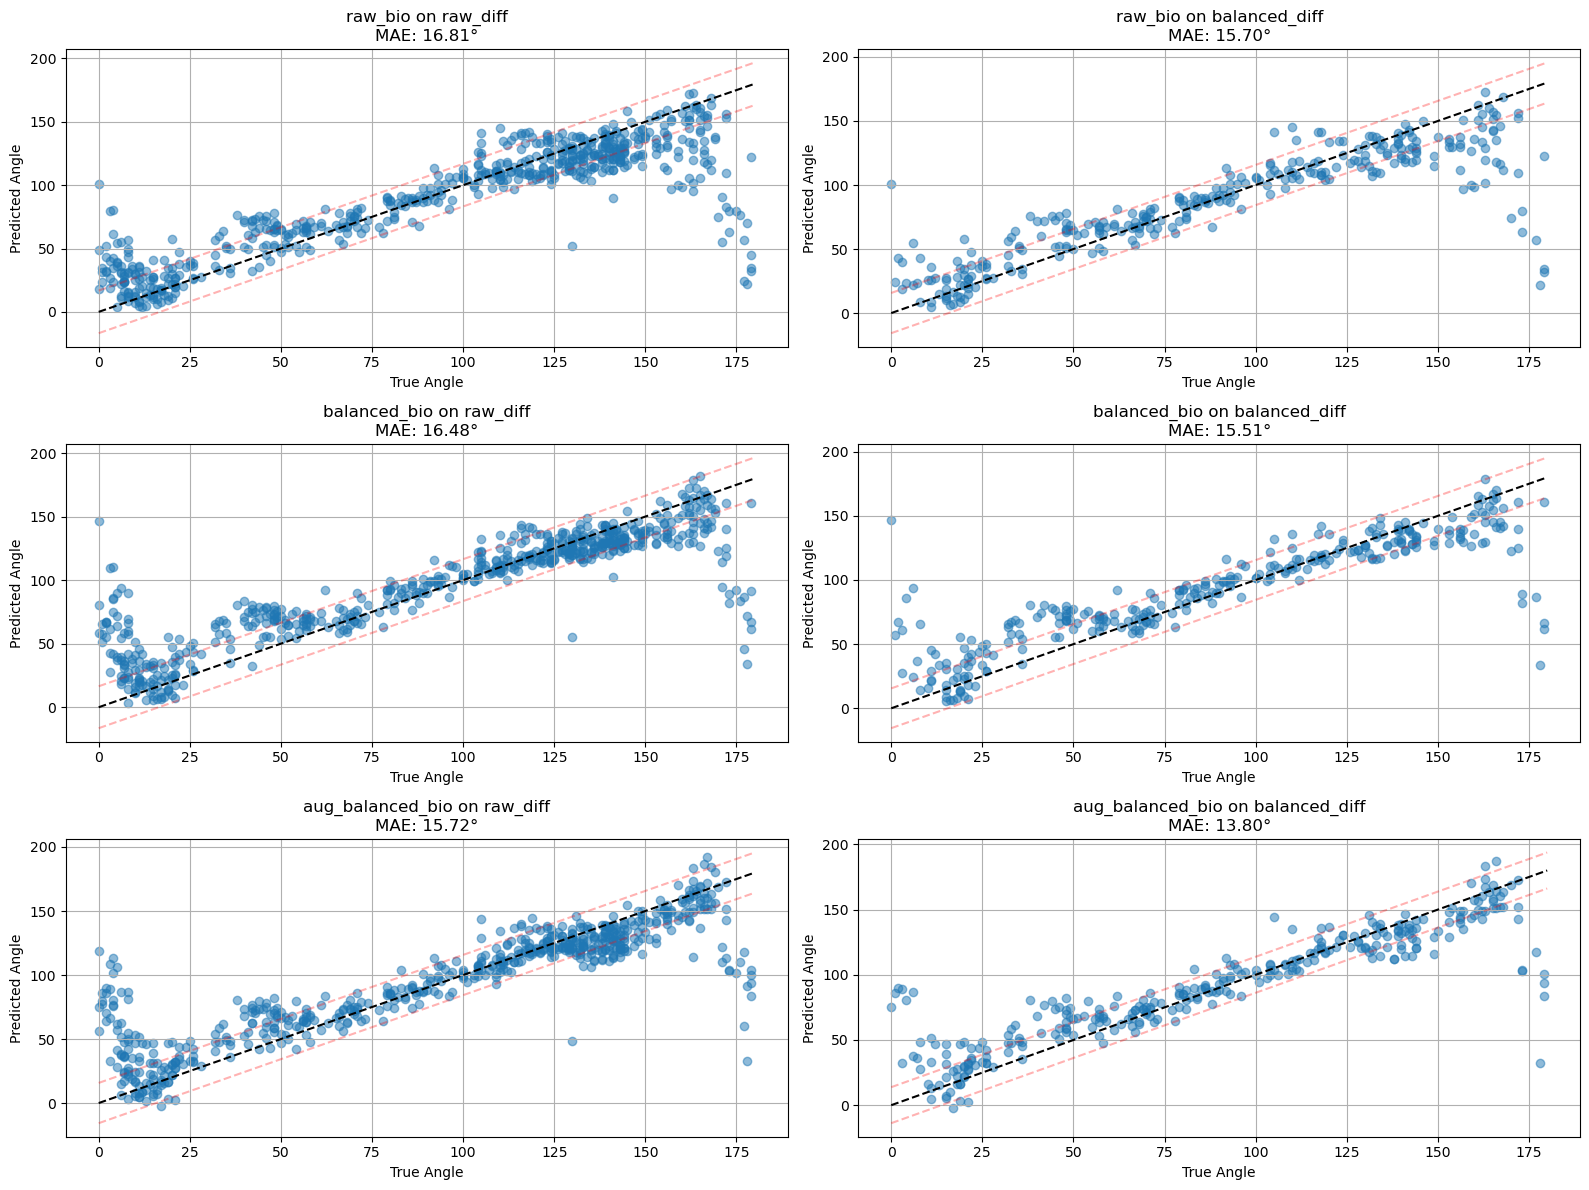

In [7]:
def plot_prediction_comparison(results):
    """Plot prediction vs true values for each test set"""
    n_models = len(results)
    test_sets = [key for key in results[0].keys() if key.endswith('_true')]
    n_sets = len(test_sets)
    
    fig, axes = plt.subplots(n_models, n_sets, figsize=(8*n_sets, 4*n_models))
    if n_models == 1:
        axes = [axes]
    
    for i, result in enumerate(results):
        for j, test_set in enumerate(test_sets):
            set_name = test_set[:-5]  # Remove '_true'
            true_vals = result[f'{set_name}_true']
            pred_vals = result[f'{set_name}_pred']
            mae = result[f'{set_name}_mae']
            
            ax = axes[i][j] if n_sets > 1 else axes[i]
            ax.scatter(true_vals, pred_vals, alpha=0.5)
            ax.plot([0, 180], [0, 180], 'k--')
            ax.set_xlabel('True Angle')
            ax.set_ylabel('Predicted Angle')
            ax.set_title(f'{result["model_name"]} on {set_name}\nMAE: {mae:.2f}°')
            ax.grid(True)
            
            # Plot error bounds
            ax.plot([0, 180], [mae, 180+mae], 'r--', alpha=0.3)
            ax.plot([0, 180], [-mae, 180-mae], 'r--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot predictions
plot_prediction_comparison(results)

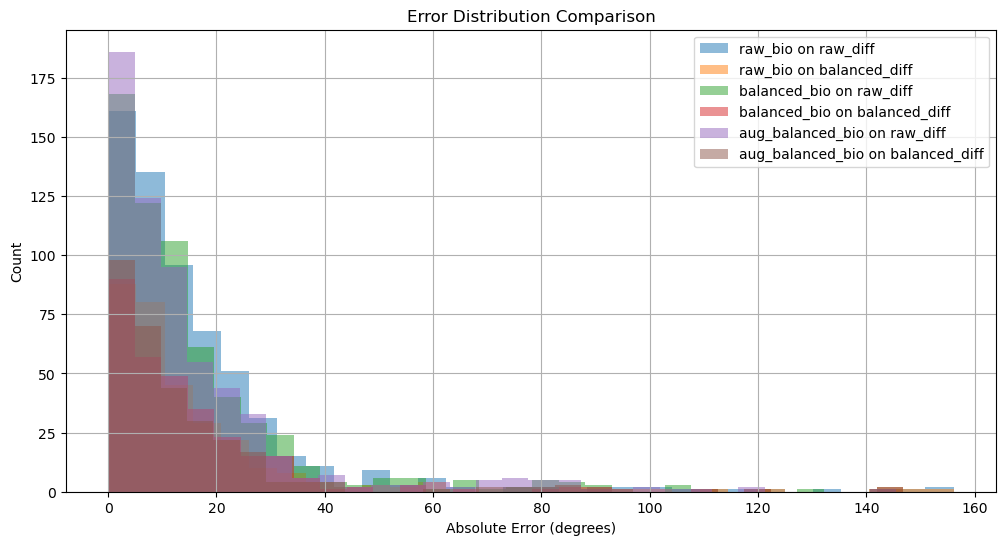

In [8]:
def plot_error_distribution(results):
    """Plot error distributions for each model and test set"""
    test_sets = [key for key in results[0].keys() if key.endswith('_true')]
    
    plt.figure(figsize=(12, 6))
    
    for result in results:
        for test_set in test_sets:
            set_name = test_set[:-5]  # Remove '_true'
            errors = np.abs(result[f'{set_name}_pred'] - result[f'{set_name}_true'])
            plt.hist(errors, bins=30, alpha=0.5, 
                    label=f'{result["model_name"]} on {set_name}')
    
    plt.xlabel('Absolute Error (degrees)')
    plt.ylabel('Count')
    plt.title('Error Distribution Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot error distributions
plot_error_distribution(results)